**READING THE DATASET**

In [31]:
# LOAD THE LIBRARIES
import pandas as pd
import numpy as np
#import pandas_profiling as pp
#from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks

# Importing all necessary libraries

from math import sqrt
import xgboost as xgb
import lightgbm as lgb
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from functools import partial
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from bayes_opt import BayesianOptimization

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score, KFold

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [32]:
train = pd.read_csv('./ReNew_Participants_Data/train.csv')
test = pd.read_csv('./ReNew_Participants_Data/test.csv')

print("The Wind Turbine training dataset has", train.shape[0], "records, each with",train.shape[1],"attributes.")
print("The Wind Turbine test dataset has", test.shape[0], "records, each with",test.shape[1],"attributes.")

train.head()

The Wind Turbine training dataset has 909604 records, each with 16 attributes.
The Wind Turbine test dataset has 303202 records, each with 14 attributes.


,timestamp,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,reactive_power,wind_direction_raw,wind_speed_raw,wind_speed_turbulence,turbine_id,Target
0,2021-02-19 20:18:00,816.636759,834.917206,31.694380,1159.616602,65.954214,917.897085,31.881972,31.504713,141.457644,165.501518,280.864782,7.057000,0.544082,Turbine_108,47.582787
1,2021-04-27 04:55:00,419.107829,421.050873,12.894948,928.747996,59.571319,445.554250,32.423705,32.755770,89.186457,113.835236,299.552460,5.474937,0.469031,Turbine_18,46.070328
2,2021-01-25 06:26:00,1303.530558,1337.566142,16.648388,1201.219775,61.270498,1364.716003,11.446849,18.332985,230.622309,281.452253,84.960106,8.092457,0.622318,Turbine_105,39.989236
3,2021-10-30 03:47:00,61.494872,53.481008,28.388141,769.806122,40.674348,14.324897,34.253204,32.662889,66.211015,75.017531,87.261119,4.071032,0.760719,Turbine_15,46.056587
4,2021-03-15 00:39:00,593.514364,611.659108,31.519527,1046.916768,64.341763,599.020172,32.405586,31.466387,137.163938,160.202421,313.724818,6.357943,0.346068,Turbine_01,54.346095


In [33]:
test.head()

,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,reactive_power,wind_direction_raw,wind_speed_raw,wind_speed_turbulence,turbine_id
0,15.507537,19.956882,40.233264,410.538834,57.357366,84.008399,48.826597,45.363477,2.419202,1.468876,156.399396,2.438629,0.790435,Turbine_14
1,472.577255,478.373881,12.306687,965.077563,51.796728,492.531362,27.457511,24.045565,96.152070,119.378235,56.443802,5.900371,0.544198,Turbine_19
2,447.829615,451.158264,29.106771,948.035899,60.493098,393.151576,39.410553,35.715697,90.251529,117.192635,224.540263,5.924923,0.513481,Turbine_14
3,254.014336,249.438965,27.074900,804.963776,55.741899,178.715101,29.476841,31.151895,89.273838,105.086257,182.151426,4.409707,0.448881,Turbine_120
4,1174.930566,1202.654077,32.148434,1199.754858,67.272313,1115.850317,31.920549,30.864276,189.731988,236.053320,261.672180,7.822326,0.561465,Turbine_158


In [34]:
# We will change the Timestamp columns
train['timestamp'] = pd.to_datetime(train['timestamp'])

In [35]:
train.drop(['timestamp'],axis=1,inplace=True)

In [36]:
# Check for null
train.isnull().sum()

active_power_calculated_by_converter      0
active_power_raw                          0
ambient_temperature                       0
generator_speed                           0
generator_winding_temp_max                0
grid_power10min_average                   0
nc1_inside_temp                           0
nacelle_temp                              0
reactice_power_calculated_by_converter    0
reactive_power                            0
wind_direction_raw                        0
wind_speed_raw                            0
wind_speed_turbulence                     0
turbine_id                                0
Target                                    0
dtype: int64

There are no NULL values to deal with.

In [37]:
# Creating a Numerical dataframe and omitting Timestamp column
train_num = train.select_dtypes(["float64"])
train_cat = train.select_dtypes(["object"])
train_num.head()

,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,reactive_power,wind_direction_raw,wind_speed_raw,wind_speed_turbulence,Target
0,816.636759,834.917206,31.694380,1159.616602,65.954214,917.897085,31.881972,31.504713,141.457644,165.501518,280.864782,7.057000,0.544082,47.582787
1,419.107829,421.050873,12.894948,928.747996,59.571319,445.554250,32.423705,32.755770,89.186457,113.835236,299.552460,5.474937,0.469031,46.070328
2,1303.530558,1337.566142,16.648388,1201.219775,61.270498,1364.716003,11.446849,18.332985,230.622309,281.452253,84.960106,8.092457,0.622318,39.989236
3,61.494872,53.481008,28.388141,769.806122,40.674348,14.324897,34.253204,32.662889,66.211015,75.017531,87.261119,4.071032,0.760719,46.056587
4,593.514364,611.659108,31.519527,1046.916768,64.341763,599.020172,32.405586,31.466387,137.163938,160.202421,313.724818,6.357943,0.346068,54.346095


In [38]:
train_cat.head()

,turbine_id
0,Turbine_108
1,Turbine_18
2,Turbine_105
3,Turbine_15
4,Turbine_01


In [39]:
from sklearn.preprocessing import LabelEncoder
# Label Encoding the categorical columns
le = LabelEncoder()

# Encode turbine_id
le.fit(train_cat.turbine_id)
train_cat.turbine_id = le.transform(train_cat.turbine_id)

train_cat.head()

,turbine_id
0,4
1,12
2,3
3,10
4,0


In [40]:
train_num.skew(axis=0)

active_power_calculated_by_converter      1.094894
active_power_raw                          1.079560
ambient_temperature                      -0.405606
generator_speed                          -0.432870
generator_winding_temp_max                0.482791
grid_power10min_average                   1.008062
nc1_inside_temp                           0.040530
nacelle_temp                             -0.427542
reactice_power_calculated_by_converter    1.731298
reactive_power                            1.638332
wind_direction_raw                       -0.363971
wind_speed_raw                            0.718327
wind_speed_turbulence                     2.205472
Target                                    0.705359
dtype: float64

**DATA VISUALIZATION**

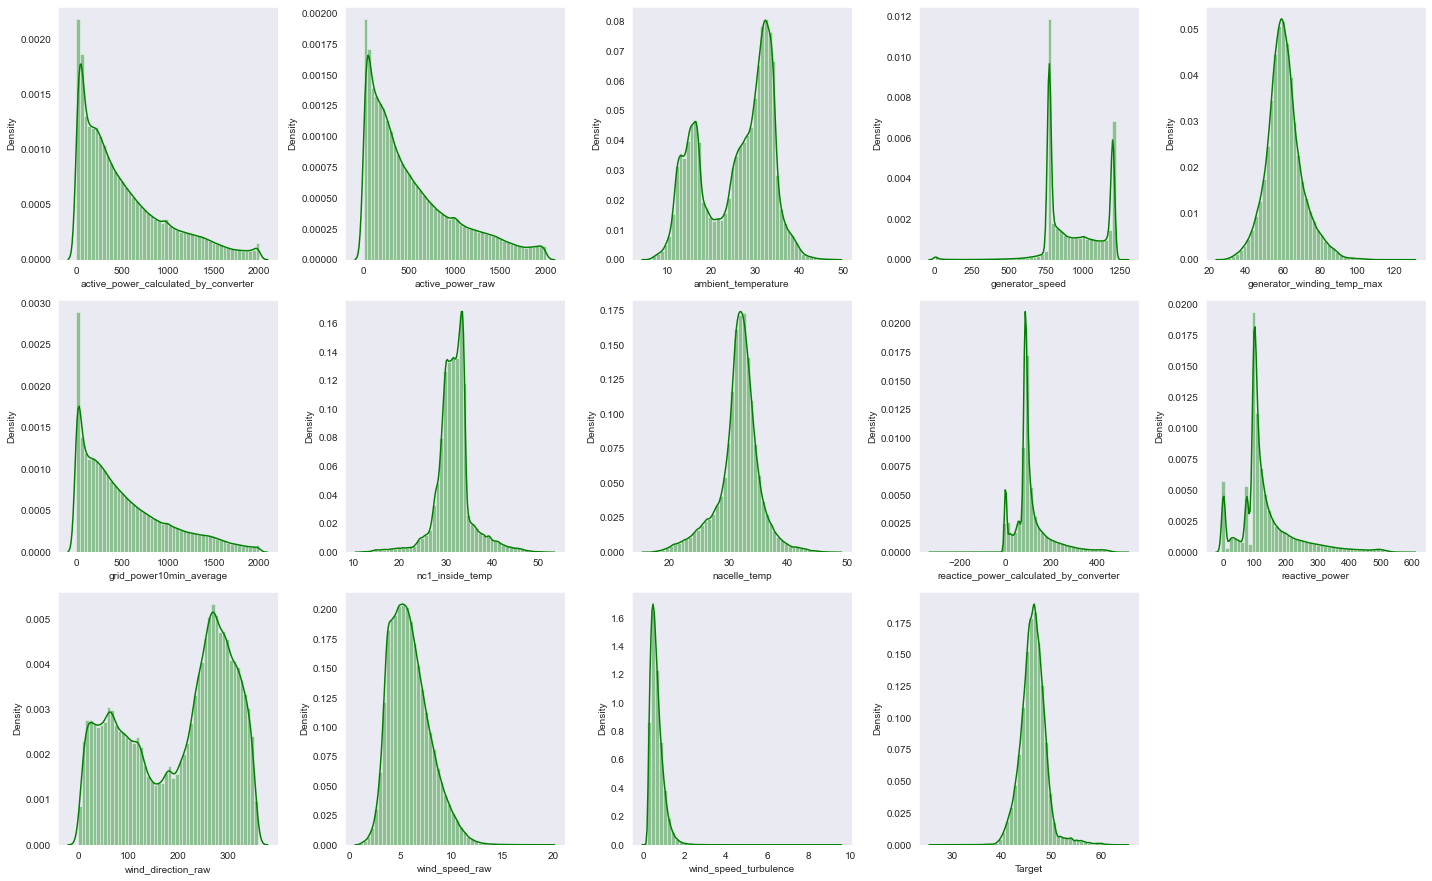

In [41]:
# Plotting the distributions of the numerical features
plt.figure(figsize=(20,16))

for i, col in enumerate(list(train_num)):
    plt.subplot(4,5,i+1)
    sns.distplot(train_num[col], color='g', kde=True, label='data')
    plt.grid()
    plt.tight_layout()

Some are normally distributed; and some left skewed. The target variable ('Target') is normally distributed. Let's apply a power transformer on the data and see how that affects the distributions.

In [42]:
# Applying normalization & transformation to see if it reduces the impact of outliers
from sklearn.preprocessing import PowerTransformer

# Init
pt = PowerTransformer()

cols = train_num.columns[train_num.columns != 'Target']
train_num[cols] = pt.fit_transform(train_num[cols])
train_num.head()

,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,reactive_power,wind_direction_raw,wind_speed_raw,wind_speed_turbulence,Target
0,0.804489,0.812812,0.754969,1.217683,0.577310,0.924106,0.023750,-0.099916,0.491302,0.492280,0.777760,0.682465,-0.181267,47.582787
1,0.105511,0.091834,-1.508825,-0.049678,-0.067461,0.154954,0.162061,0.262363,-0.182065,-0.061024,0.949197,-0.090553,-0.532215,46.070328
2,1.393659,1.403914,-1.131586,1.455545,0.108487,1.440377,-4.905537,-3.179904,1.480174,1.499626,-1.083126,1.115842,0.137915,39.989236
3,-1.228872,-1.356495,0.294849,-0.865130,-2.296073,-1.659102,0.631422,0.235060,-0.516278,-0.557574,-1.060222,-0.938929,0.609483,46.056587
4,0.451064,0.466452,0.730050,0.587518,0.418478,0.445702,0.157430,-0.110827,0.439360,0.439541,1.078729,0.359877,-1.226905,54.346095


In [43]:
train_num.skew(axis=0)

active_power_calculated_by_converter     -0.110339
active_power_raw                         -0.097555
ambient_temperature                      -0.232208
generator_speed                          -0.023327
generator_winding_temp_max                0.016822
grid_power10min_average                  -0.166983
nc1_inside_temp                           0.202477
nacelle_temp                              0.119152
reactice_power_calculated_by_converter   -1.465851
reactive_power                            0.100957
wind_direction_raw                       -0.406996
wind_speed_raw                           -0.001060
wind_speed_turbulence                     0.046962
Target                                    0.705359
dtype: float64

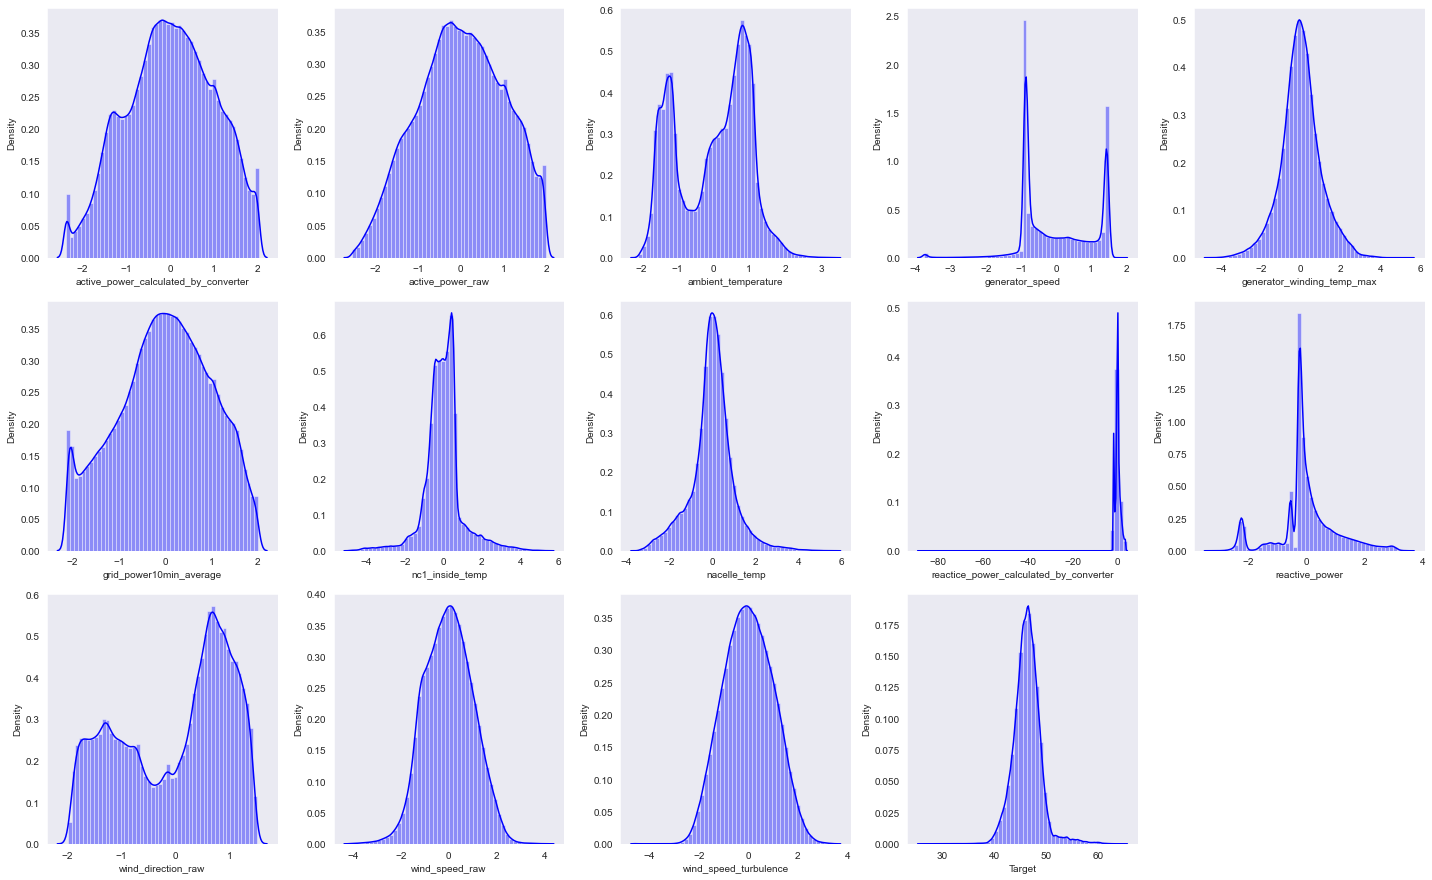

In [44]:
# Plotting the distributions of the numerical features after applying log transformation
plt.figure(figsize=(20,16))

for i, col in enumerate(list(train_num)):
    plt.subplot(4,5,i+1)
    sns.distplot(train_num[col], color='b', kde=True, label='data')
    plt.grid()
    plt.tight_layout()

The Power transformer has improved the distribution. There are some outliners for the " reactice_power_calculated_by_converter" feature; we will see how to treat that in later stages. But for now this transformation can be applied and taken forward.

In [45]:
train_cat.head()

,turbine_id
0,4
1,12
2,3
3,10
4,0


In [49]:
train = pd.concat([train_num, train_cat], axis=1)
train = train.drop('turbine_id', axis=1)
train.head()

,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,reactive_power,wind_direction_raw,wind_speed_raw,wind_speed_turbulence,Target
0,0.804489,0.812812,0.754969,1.217683,0.577310,0.924106,0.023750,-0.099916,0.491302,0.492280,0.777760,0.682465,-0.181267,47.582787
1,0.105511,0.091834,-1.508825,-0.049678,-0.067461,0.154954,0.162061,0.262363,-0.182065,-0.061024,0.949197,-0.090553,-0.532215,46.070328
2,1.393659,1.403914,-1.131586,1.455545,0.108487,1.440377,-4.905537,-3.179904,1.480174,1.499626,-1.083126,1.115842,0.137915,39.989236
3,-1.228872,-1.356495,0.294849,-0.865130,-2.296073,-1.659102,0.631422,0.235060,-0.516278,-0.557574,-1.060222,-0.938929,0.609483,46.056587
4,0.451064,0.466452,0.730050,0.587518,0.418478,0.445702,0.157430,-0.110827,0.439360,0.439541,1.078729,0.359877,-1.226905,54.346095


In [47]:
# Encode turbine_id in Test dataset
le.fit(test.turbine_id)
test.turbine_id = le.transform(test.turbine_id)

test.head()

,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,reactive_power,wind_direction_raw,wind_speed_raw,wind_speed_turbulence,turbine_id
0,15.507537,19.956882,40.233264,410.538834,57.357366,84.008399,48.826597,45.363477,2.419202,1.468876,156.399396,2.438629,0.790435,9
1,472.577255,478.373881,12.306687,965.077563,51.796728,492.531362,27.457511,24.045565,96.152070,119.378235,56.443802,5.900371,0.544198,13
2,447.829615,451.158264,29.106771,948.035899,60.493098,393.151576,39.410553,35.715697,90.251529,117.192635,224.540263,5.924923,0.513481,9
3,254.014336,249.438965,27.074900,804.963776,55.741899,178.715101,29.476841,31.151895,89.273838,105.086257,182.151426,4.409707,0.448881,5
4,1174.930566,1202.654077,32.148434,1199.754858,67.272313,1115.850317,31.920549,30.864276,189.731988,236.053320,261.672180,7.822326,0.561465,11


In [50]:
t_cols = test.columns[test.columns != 'turbine_id']
test[t_cols] = pt.fit_transform(test[t_cols])
test = test.drop('turbine_id', axis=1)
test.head()

,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,reactive_power,wind_direction_raw,wind_speed_raw,wind_speed_turbulence
0,-1.723836,-1.735326,2.375855,-2.633814,-0.300949,-1.009350,4.250266,4.521073,-1.909325,-2.287695,-0.544335,-2.262554,0.703888
1,0.195297,0.193792,-1.465541,0.174494,-0.922109,0.208734,-1.104040,-2.030455,-0.058958,0.019877,-1.296292,0.136080,-0.168087
2,0.142541,0.135936,0.313714,0.084309,0.030459,-0.004352,1.922951,1.163922,-0.140962,-0.005309,0.100469,0.148597,-0.306887
3,-0.351118,-0.385676,0.019770,-0.674330,-0.476834,-0.598942,-0.579593,-0.200453,-0.154755,-0.149401,-0.319376,-0.715183,-0.627344
4,1.274329,1.280347,0.803413,1.416141,0.706159,1.193513,0.048932,-0.281699,1.044820,1.128085,0.520383,1.008786,-0.093564


**FEATURE SELECTION**

In [51]:
X = train.drop('Target', axis=1)
y = train['Target']

In [52]:
X.shape[1]

13

In [53]:
X.head()

,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,reactive_power,wind_direction_raw,wind_speed_raw,wind_speed_turbulence
0,0.804489,0.812812,0.754969,1.217683,0.577310,0.924106,0.023750,-0.099916,0.491302,0.492280,0.777760,0.682465,-0.181267
1,0.105511,0.091834,-1.508825,-0.049678,-0.067461,0.154954,0.162061,0.262363,-0.182065,-0.061024,0.949197,-0.090553,-0.532215
2,1.393659,1.403914,-1.131586,1.455545,0.108487,1.440377,-4.905537,-3.179904,1.480174,1.499626,-1.083126,1.115842,0.137915
3,-1.228872,-1.356495,0.294849,-0.865130,-2.296073,-1.659102,0.631422,0.235060,-0.516278,-0.557574,-1.060222,-0.938929,0.609483
4,0.451064,0.466452,0.730050,0.587518,0.418478,0.445702,0.157430,-0.110827,0.439360,0.439541,1.078729,0.359877,-1.226905


**Correlation check for multi-collinearity**

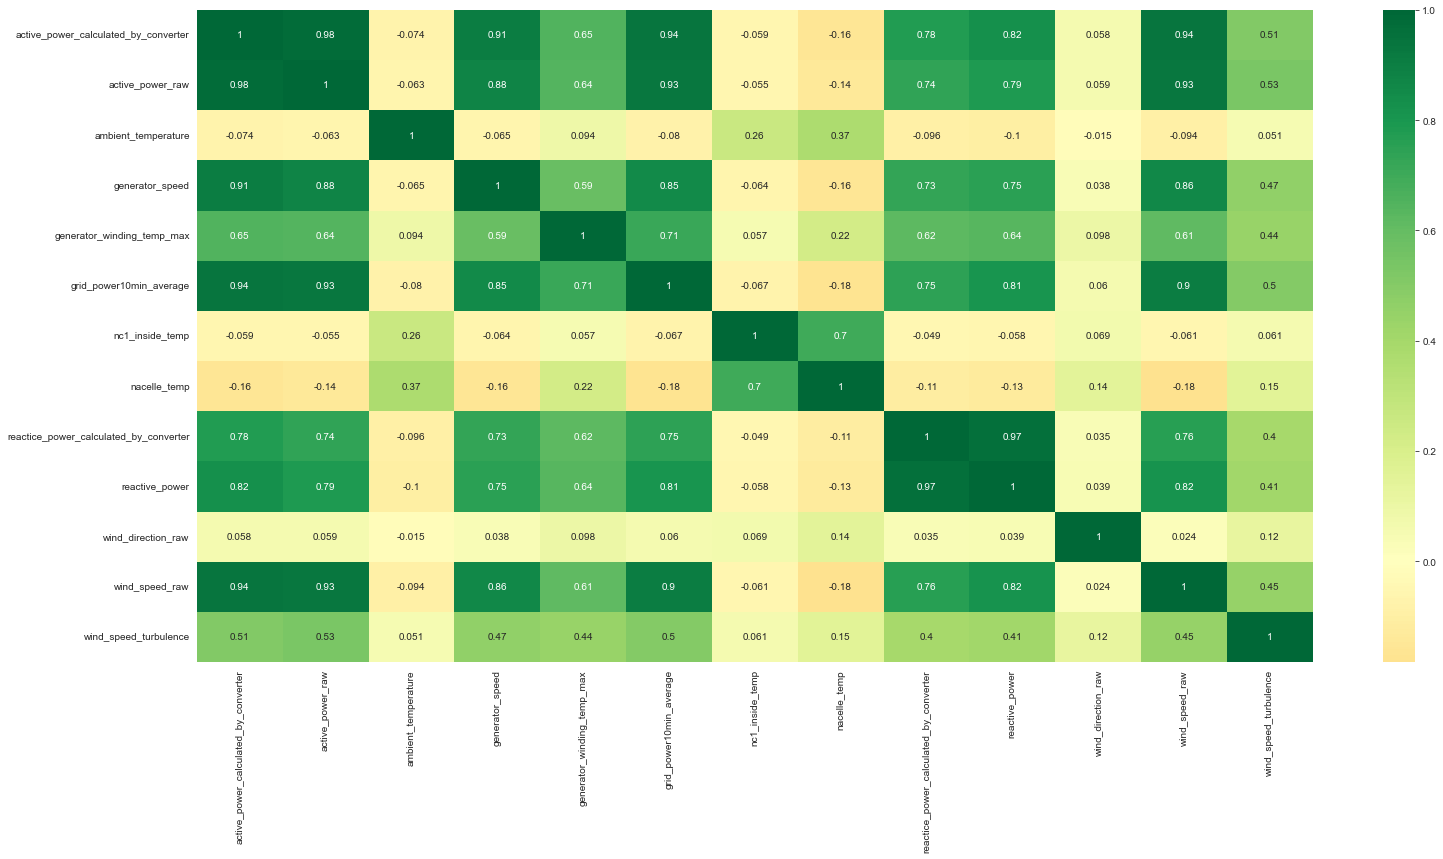

In [54]:
# Plotting a heatmap plot

from turtle import color
plt.figure(figsize=(25,12))
p = sns.heatmap(data=X.corr(method='pearson'), cmap='RdYlGn', annot=True, center=0)

**Correlation of Independent Variables**

Based on the coefficient values some of the independent variables are highly correlated to each other (value >=0.8). This means we may need to drop one of these to ensure we do not overfit the model. We will analyze further with some other methods (VIF, Feature Selection and Embedded methods) to come to an optimal set of features.

* active_power_calculated_by_converter & active_power_raw 
* active_power_calculated_by_converter & wind_speed_raw
* active_power_calculated_by_converter & grid_power10min_average
* active_power_raw & wind_speed_raw
* active_power_raw & grid_power10min_average
* generator_speed & active_power_calculated_by_converter  
* reactice_power_calculated_by_converter & reactive_power

In [55]:
X.corrwith(y)

active_power_calculated_by_converter     -0.047809
active_power_raw                         -0.043599
ambient_temperature                       0.427182
generator_speed                          -0.042325
generator_winding_temp_max                0.300506
grid_power10min_average                  -0.054231
nc1_inside_temp                           0.201047
nacelle_temp                              0.503090
reactice_power_calculated_by_converter   -0.040941
reactive_power                           -0.045422
wind_direction_raw                        0.070613
wind_speed_raw                           -0.071601
wind_speed_turbulence                     0.081114
dtype: float64

**VIF Check**

In [56]:
# Import VIF library for multi-collinearity check
from statsmodels.stats.outliers_influence import variance_inflation_factor 

def calc_vif(dataframe):

    # calculating VIF
    vif = pd.DataFrame()
    vif["Variables"] = dataframe.columns
    vif["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    vif = vif.sort_values(ascending=False, by="VIF")
    return(vif)

calc_vif(X) 

,Variables,VIF
0,active_power_calculated_by_converter,38.181699
1,active_power_raw,26.281814
9,reactive_power,21.902869
8,reactice_power_calculated_by_converter,17.417872
5,grid_power10min_average,12.335362
11,wind_speed_raw,10.142883
3,generator_speed,5.853446
7,nacelle_temp,3.367055
4,generator_winding_temp_max,3.303477
6,nc1_inside_temp,2.237131


* VIF starts at 1 and has no upper limit
* VIF = 1, no correlation between the independent variable and the other variables
* VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others

I will remove one column at a time, starting with the highest VIF value, and see how it impacts the other VIF values.

In [57]:
X = X.drop(['active_power_calculated_by_converter','active_power_raw', 'reactive_power', 'reactice_power_calculated_by_converter'], axis=1)
calc_vif(X)

,Variables,VIF
3,grid_power10min_average,9.079282
7,wind_speed_raw,6.630188
1,generator_speed,4.340181
5,nacelle_temp,3.317795
2,generator_winding_temp_max,3.055848
4,nc1_inside_temp,2.220333
8,wind_speed_turbulence,1.508332
0,ambient_temperature,1.168021
6,wind_direction_raw,1.045255


In [58]:
X.head()

,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,wind_direction_raw,wind_speed_raw,wind_speed_turbulence
0,0.754969,1.217683,0.577310,0.924106,0.023750,-0.099916,0.777760,0.682465,-0.181267
1,-1.508825,-0.049678,-0.067461,0.154954,0.162061,0.262363,0.949197,-0.090553,-0.532215
2,-1.131586,1.455545,0.108487,1.440377,-4.905537,-3.179904,-1.083126,1.115842,0.137915
3,0.294849,-0.865130,-2.296073,-1.659102,0.631422,0.235060,-1.060222,-0.938929,0.609483
4,0.730050,0.587518,0.418478,0.445702,0.157430,-0.110827,1.078729,0.359877,-1.226905


**Wrapper Methods**

* Sequential Feature Selector - Forward Selection 
* Backward Elimination - Recursive Feature Elimination (RFE)
* Stepwise Selection: Bi-directional with a combination of Forward Selection & Backward Elimination

**Forward Selection Method - SFS() from Mlxtend**

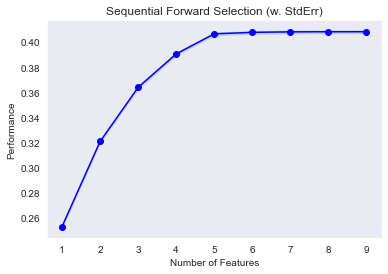

In [59]:
# Sequential Feature Selection (SFS)
sfs = SFS(LinearRegression(), k_features=9, forward=True, floating=False, scoring='r2', cv=5)
sfs.fit(X, y)
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

We can see that the performance fairly remains same after k_features reaches 6. 

In [60]:
sfs = SFS(LinearRegression(), k_features=6, forward=True, floating=False, scoring='r2', cv=5)
sfs.fit(X, y)
#sfs.subsets_[6]['feature_names']
selected_1 = pd.DataFrame({'Feature' : sfs.k_feature_names_, 'Score' : sfs.k_score_})
print(selected_1)

                      Feature     Score
0         ambient_temperature  0.407721
1  generator_winding_temp_max  0.407721
2     grid_power10min_average  0.407721
3             nc1_inside_temp  0.407721
4                nacelle_temp  0.407721
5       wind_speed_turbulence  0.407721


**SelectKBest with Pearson's f_regression**

In [61]:
best_features = SelectKBest(score_func=f_regression, k='all')
fit = best_features.fit(X,y)

feat_scores = pd.DataFrame({'Feature': X.columns, 'Pearsons Score' : fit.scores_})
print(feat_scores.sort_values(by=['Pearsons Score'], ascending=False))

                      Feature  Pearsons Score
5                nacelle_temp   308233.310336
0         ambient_temperature   203039.981737
2  generator_winding_temp_max    90294.303811
4             nc1_inside_temp    38314.508929
8       wind_speed_turbulence     6024.374809
7              wind_speed_raw     4687.293770
6          wind_direction_raw     4558.237670
3     grid_power10min_average     2682.990855
1             generator_speed     1632.366452


In [62]:
selected_2 = feat_scores.nlargest(6, 'Pearsons Score')
print(selected_2)

                      Feature  Pearsons Score
5                nacelle_temp   308233.310336
0         ambient_temperature   203039.981737
2  generator_winding_temp_max    90294.303811
4             nc1_inside_temp    38314.508929
8       wind_speed_turbulence     6024.374809
7              wind_speed_raw     4687.293770


**Backward Elimination: Recursive Forward Elimination Method RFE() from Sklearn**

In [63]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
np.random.seed(123)
#names = pd.DataFrame(X.columns)
model = LinearRegression()

#Define RFE 
rfe = RFE(model, step=1, n_features_to_select=6) 
my_values = rfe.fit(X,y)

#Create a dataframe for the results
df_RFE_results = []
for i in range(X.shape[1]):
    df_RFE_results.append(
        {
            'Feature' : X.columns[i],
            'Selected' : my_values.support_[i],
            'RFE_Ranking' : my_values.ranking_[i]
        }
    )

df_RFE_results = pd.DataFrame(df_RFE_results)
df_RFE_results.index.name = 'Columns'
df_RFE_results

,Feature,Selected,RFE_Ranking
Columns,,,
0,ambient_temperature,True,1
1,generator_speed,False,2
2,generator_winding_temp_max,True,1
3,grid_power10min_average,True,1
4,nc1_inside_temp,True,1
5,nacelle_temp,True,1
6,wind_direction_raw,False,4
7,wind_speed_raw,False,3
8,wind_speed_turbulence,True,1


In [64]:
selected_3 = df_RFE_results[df_RFE_results['RFE_Ranking'] == 1]
print(selected_3)

                            Feature  Selected  RFE_Ranking
Columns                                                   
0               ambient_temperature      True            1
2        generator_winding_temp_max      True            1
3           grid_power10min_average      True            1
4                   nc1_inside_temp      True            1
5                      nacelle_temp      True            1
8             wind_speed_turbulence      True            1


In [65]:
feat_list = {'SelectKBest' : selected_1['Feature'],
            'SFS FS' : selected_2['Feature'], 
            'RFE Linear' : selected_3['Feature']
            }
key_features = pd.DataFrame(feat_list)
key_features = key_features.apply(lambda x: pd.Series(x.dropna().values))
key_features

,SelectKBest,SFS FS,RFE Linear
0,ambient_temperature,ambient_temperature,ambient_temperature
1,generator_winding_temp_max,generator_winding_temp_max,generator_winding_temp_max
2,grid_power10min_average,nc1_inside_temp,grid_power10min_average
3,nc1_inside_temp,nacelle_temp,nc1_inside_temp
4,nacelle_temp,wind_speed_raw,nacelle_temp
5,wind_speed_turbulence,wind_speed_turbulence,wind_speed_turbulence


**MODEL BUILDING - ALL FEATURES**

We will now test multiple REGRESSION models (Linear, RandomForest, Bagging, XGBoost & K-Neighbours) with the full dataset and compare the results. 

Later on, we will do the same with the selected featuresß dataset.

In [66]:
test.head()

,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,reactive_power,wind_direction_raw,wind_speed_raw,wind_speed_turbulence
0,-1.723836,-1.735326,2.375855,-2.633814,-0.300949,-1.009350,4.250266,4.521073,-1.909325,-2.287695,-0.544335,-2.262554,0.703888
1,0.195297,0.193792,-1.465541,0.174494,-0.922109,0.208734,-1.104040,-2.030455,-0.058958,0.019877,-1.296292,0.136080,-0.168087
2,0.142541,0.135936,0.313714,0.084309,0.030459,-0.004352,1.922951,1.163922,-0.140962,-0.005309,0.100469,0.148597,-0.306887
3,-0.351118,-0.385676,0.019770,-0.674330,-0.476834,-0.598942,-0.579593,-0.200453,-0.154755,-0.149401,-0.319376,-0.715183,-0.627344
4,1.274329,1.280347,0.803413,1.416141,0.706159,1.193513,0.048932,-0.281699,1.044820,1.128085,0.520383,1.008786,-0.093564


In [67]:
# SPLIT TRAIN DATASET INTO TRAIN & VALIDATION TO TEST MODEL BEFORE PREDICTING ON TEST DATASET

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.9, random_state=42)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(818643, 9) (818643,) (90961, 9) (90961,)


LINEAR REGRESSION

In [92]:
# Fit a simple Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_val)

lr_train_acc = (lr_model.score(X_train, y_train))*100
lr_val_acc = (lr_model.score(X_val, y_val))*100
mape_lr = mean_absolute_percentage_error(y_val, lr_pred)

print(f"Training accuracy: {lr_train_acc} %")
print(f"Validation accuracy: {lr_val_acc} %")
print(f"Linear Regression Mean Absolute Percent Error: {mape_lr}")


Training accuracy: 42.35309244111218 %
Validation accuracy: 42.557695776876294 %
Linear Regression Mean Absolute Percent Error: 0.029278919476377552


RANDOM FOREST REGRESSION

In [93]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_val)

rf_train_acc = (rf_model.score(X_train, y_train))*100
rf_val_acc = (rf_model.score(X_val, y_val))*100
mape_rf = mean_absolute_percentage_error(y_val, rf_pred)

print(f"Training accuracy: {rf_train_acc} %")
print(f"Validation accuracy: {rf_val_acc} %")
print(f"Random Forest Model Mean Absolute Percent Error: {mape_rf}")

Training accuracy: 97.63771988506869 %
Validation accuracy: 83.10129443322514 %
Random Forest Model Mean Absolute Percent Error: 0.013766202313079342


In [94]:
pd.DataFrame(rf_model.feature_importances_, index=X.columns, columns=['Score']).sort_values('Score', ascending=False)

,Score
nacelle_temp,0.237520
ambient_temperature,0.235737
turbine_id,0.147577
generator_winding_temp_max,0.102128
nc1_inside_temp,0.074793
wind_direction_raw,0.073931
grid_power10min_average,0.045757
wind_speed_turbulence,0.041202
wind_speed_raw,0.021850
generator_speed,0.019505


In [101]:
from pprint import pprint

pprint(rf_model.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [95]:
from sklearn.model_selection import RandomizedSearchCV
# #rf_model = RandomForestRegressor()

# rf_grid = {'max_features':[3],
#           'n_estimators':[100,150,200,250,300,350],
#           'max_depth':[7,9,12,15,25,35],
#           'min_samples_split':[2,5,8,12,15,30,50,80],
#           'min_samples_leaf':[5,10,15,20,30]}

# rf_search_result = RandomizedSearchCV(estimator=rf_model, param_distributions=rf_grid, n_iter=100, cv=3, verbose=2, n_jobs=-1, random_state=42)
# rf_search_result.fit(X_train, y_train)

In [96]:
#rf_search_result.best_params_

In [59]:
# rf_params = {'n_estimators': 350,
#           'min_samples_split': 8,
#           'min_samples_leaf' : 5,
#           'max_features' : 3,
#           'max_depth' : 35
#           }
# rf_model = RandomForestRegressor(**rf_params)
# rf_model.fit(X_train, y_train)

# rf_pred = rf_model.predict(X_val)

# rf_train_acc = (rf_model.score(X_train, y_train))*100
# rf_val_acc = (rf_model.score(X_val, y_val))*100
# mape_rf = mean_absolute_percentage_error(y_val, rf_pred)

# print(f"Training accuracy: {rf_train_acc} %")
# print(f"Validation accuracy: {rf_val_acc} %")
# print(f"Random Forest Model Mean Absolute Percent Error: {mape_rf}")

RandomForestRegressor(max_depth=35, max_features=3, min_samples_leaf=5,
                      min_samples_split=8, n_estimators=350)

rf_model=RandomForestRegressor(**rf_search_result.best_params_)

rf_pred = rf_model.predict(X_val)

rf_train_acc = (rf_model.score(X_train, y_train))*100
rf_val_acc = (rf_model.score(X_val, y_val))*100
mape_rf = mean_absolute_percentage_error(y_val, rf_pred)

print(f"Training accuracy: {rf_train_acc} %")
print(f"Validation accuracy: {rf_val_acc} %")
print(f"Random Forest Model Mean Absolute Percent Error: {mape_rf}")

CATBOOST REGRESSOR

In [102]:
from catboost import CatBoostRegressor, cv

cat_model = CatBoostRegressor(loss_function='MAPE')
cat_model.fit(X_train, y_train)
cat_pred = cat_model.predict(X_val)

cat_train_acc = (cat_model.score(X_train, y_train))*100
cat_val_acc = (cat_model.score(X_val, y_val))*100
mape_cat = mean_absolute_percentage_error(y_val, cat_pred)

print(f"Training accuracy: {cat_train_acc} %")
print(f"Validation accuracy: {cat_val_acc} %")
print(f"CatBoost Model Mean Absolute Percent Error: {mape_cat}")

0:	learn: 0.0406591	total: 184ms	remaining: 3m 3s
1:	learn: 0.0403407	total: 250ms	remaining: 2m 4s
2:	learn: 0.0400265	total: 380ms	remaining: 2m 6s
3:	learn: 0.0397242	total: 448ms	remaining: 1m 51s
4:	learn: 0.0394305	total: 509ms	remaining: 1m 41s
5:	learn: 0.0391525	total: 579ms	remaining: 1m 35s
6:	learn: 0.0388631	total: 636ms	remaining: 1m 30s
7:	learn: 0.0385765	total: 696ms	remaining: 1m 26s
8:	learn: 0.0382945	total: 758ms	remaining: 1m 23s
9:	learn: 0.0380207	total: 816ms	remaining: 1m 20s
10:	learn: 0.0377621	total: 872ms	remaining: 1m 18s
11:	learn: 0.0375091	total: 933ms	remaining: 1m 16s
12:	learn: 0.0372579	total: 992ms	remaining: 1m 15s
13:	learn: 0.0370147	total: 1.05s	remaining: 1m 13s
14:	learn: 0.0367813	total: 1.11s	remaining: 1m 12s
15:	learn: 0.0365350	total: 1.17s	remaining: 1m 12s
16:	learn: 0.0363198	total: 1.23s	remaining: 1m 11s
17:	learn: 0.0361082	total: 1.29s	remaining: 1m 10s
18:	learn: 0.0358978	total: 1.35s	remaining: 1m 9s
19:	learn: 0.0356850	total

LIGHTGBM REGRESSION

In [105]:
lgb_model = LGBMRegressor(n_estimators=1000)
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_val)

lgb_train_acc = (lgb_model.score(X_train, y_train))*100
lgb_val_acc = (lgb_model.score(X_val, y_val))*100
mape_lgb = mean_absolute_percentage_error(y_val, lgb_pred)

print(f"Training accuracy: {lgb_train_acc} %")
print(f"Validation accuracy: {lgb_val_acc} %")
print(f"CatBoost Model Mean Absolute Percent Error: {mape_lgb}")

Training accuracy: 79.66448436333154 %
Validation accuracy: 77.50515153907016 %
CatBoost Model Mean Absolute Percent Error: 0.018173348407449205


LASSO & RIDGE REGRESSION

In [106]:
from sklearn.linear_model import Ridge, Lasso

# Initiate a ridge object and fit to the training data
ridge = Ridge(alpha=0.1, fit_intercept=True, normalize=True)
ridge.fit(X_train, y_train)
rg_pred = ridge.predict(X_val)

rg_train_acc = ridge.score(X_train, y_train)*100
rg_val_acc = ridge.score(X_val, y_val)*100
mape_rg = mean_absolute_percentage_error(y_val, rg_pred)

print(f"Training accuracy: {rg_train_acc} %")
print(f"Validation accuracy: {rg_val_acc} %")
print(f"Ridge Mean Absolute Percent Error: {mape_rg}")

Training accuracy: 41.76818576170246 %
Validation accuracy: 41.94782393661605 %
Ridge Mean Absolute Percent Error: 0.029359970942286914


In [107]:
# Initiate a Lasso object and fit to the training data
lasso = Lasso(random_state=1)
lasso.fit(X_train, y_train)
ls_pred = lasso.predict(X_val)

ls_train_acc = lasso.score(X_train, y_train)*100
ls_val_acc = lasso.score(X_val, y_val)*100
mape_ls = mean_absolute_percentage_error(y_val, ls_pred)

print(f"Training accuracy: {ls_train_acc} %")
print(f"Validation accuracy: {ls_val_acc} %")
print(f"Lasso Mean Absolute Percent Error: {mape_ls}")

Training accuracy: 12.340552769331914 %
Validation accuracy: 12.289984517075869 %
Lasso Mean Absolute Percent Error: 0.03786575328291523


In [103]:
# CATBOOST_PARAMS = {
#     'random_seed':47,
#     'learning_rate':0.4,
#     'iterations':1000,
#     'max_depth':12,
#     'early_stopping_rounds':10,
#     'min_data_in_leaf':12}

**Cross-Validation on CatBoost**

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV
# cat_model = CatBoostRegressor(loss_function='MAPE')

# grid = {'depth':[3,1,2,6,4,5,7,8,9,10],
#           'iterations':[250,100,500,1000],
#           'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3],
#           'max_depth':[0,2,4,6,8,10,12,14,16],
#           'l2_leaf_reg':[3,1,5,10,100],
#           'border_count':[32,5,10,20,50,100,200],
#           'min_data_in_leaf':[1,2,3,4,5,6,7,8,9,10]}

# randomized_search_result = cat_model.randomized_search(grid,
#             X,
#             y,
#             cv=5,
#             partition_random_seed=42,
#             search_by_train_test_split=True,
#             refit=True,
#             shuffle=True,
#             stratified=None,
#             train_size=0.8,
#             verbose=0,
#             plot=False)

# cat_model.fit(X_train, y_train)
# cat_pred = cat_model.predict(X_val)

# cat_train_acc = (cat_model.score(X_train, y_train))*100
# cat_val_acc = (cat_model.score(X_val, y_val))*100
# mape_cat = mean_absolute_percentage_error(y_val, cat_pred)

# print(f"Training accuracy: {cat_train_acc} %")
# print(f"Validation accuracy: {cat_val_acc} %")
# print(f"CatBoost Model Mean Absolute Percent Error: {mape_cat}")

In [44]:
print(model.get_feature_importance(prettified=True))

                                Feature Id  Importances
0                             nacelle_temp    20.125702
1                      ambient_temperature    18.400556
2               generator_winding_temp_max    16.171039
3                          nc1_inside_temp    15.734698
4                       wind_direction_raw     8.473768
5                  grid_power10min_average     8.105800
6   reactice_power_calculated_by_converter     6.648364
7                         active_power_raw     2.561000
8                    wind_speed_turbulence     2.065475
9                          generator_speed     1.025831
10                          wind_speed_raw     0.687767


In [45]:
print(model.get_best_score())

{'learn': {'MAPE': 0.020807281315319583}}


**MODEL EVALUATION TABLE**

In [78]:
models = pd.DataFrame({
    'Model': ['Linear Regression','XGBoost Regressor', 
             'Random Forest Regressor', 'CatBoost Regressor'],
    'Training Accuracy %' : [lr_train_acc, xg_train_acc, rf_train_acc, cat_train_acc],
    'Validation Accuracy %' : [lr_val_acc, xg_val_acc, rf_val_acc, cat_val_acc],
    'MAPE Score' : [mape_lr, mape_xg, mape_rf, mape_cat]
})

models.sort_values(by = ['MAPE Score'],ascending = True)

,Model,Training Accuracy %,Validation Accuracy %,MAPE Score
3,Random Forest Regressor,96.998899,78.496042,0.015786
4,CatBoost Regressor,80.832951,67.381752,0.019251
1,XGBoost Regressor,70.877773,68.583001,0.021315
0,Linear Regression,41.124234,41.395850,0.029890
2,AdaBoost Regressor,16.117634,16.154187,0.037768


It looks like the Random Forest Regressor has performed well with the lowest MAPE value amongst all and with the highest model score overall. We will now run the same models with the features derived from RF and CatBoost Feature importance methods and check if there is a difference in the above comparison.

**MODEL BUILDING - WITH SELECTED COLUMNS FROM FEATURE SELECTION**

* ambient temperature
* generator_winding_temp_max
* nc1_inside_temp
* nacelle_temp
* grid_power10min_average
* wind_direction_raw

In [79]:
# Columns derived from the Feature Selection methods (Top 6)
sel_cols = ['ambient_temperature','generator_winding_temp_max', 'nc1_inside_temp', 'nacelle_temp',
            'wind_direction_raw', 'grid_power10min_average']

X_sel = train[sel_cols]
y = train['Target']

# creating test set of the selected feature columns for prediction
X_test = test[sel_cols]

In [80]:
# SPLIT TRAIN DATASET INTO TRAIN & VALIDATION TO TEST MODEL BEFORE PREDICTING ON TEST DATASET
X_train, X_val, y_train, y_val = train_test_split(X_sel, y, train_size=0.9, random_state=42)

X_train.shape

(818643, 6)

In [81]:
# Fit a simple Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_val)

lr_train_acc = (lr_model.score(X_train, y_train))*100
lr_val_acc = (lr_model.score(X_val, y_val))*100
mape_lr = mean_absolute_percentage_error(y_val, lr_pred)

print(f"Training accuracy: {lr_train_acc} %")
print(f"Validation accuracy: {lr_val_acc} %")
print(f"Linear Regression Mean Absolute Percent Error: {mape_lr}")

Training accuracy: 41.72593597843955 %
Validation accuracy: 41.950065354505995 %
Linear Regression Mean Absolute Percent Error: 0.029874588755913364


In [82]:
# Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_val)

rf_train_acc = (rf_model.score(X_train, y_train))*100
rf_val_acc = (rf_model.score(X_val, y_val))*100
mape_rf = mean_absolute_percentage_error(y_val, rf_pred)

print(f"Training accuracy: {rf_train_acc} %")
print(f"Validation accuracy: {rf_val_acc} %")
print(f"Random Forest Model Mean Absolute Percent Error: {mape_rf}")

Training accuracy: 96.87592280077958 %
Validation accuracy: 77.60800262636856 %
Random Forest Model Mean Absolute Percent Error: 0.015796501046984036


In [83]:
from pprint import pprint
pprint(rf_model.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [84]:
from sklearn.model_selection import RandomizedSearchCV
rf_model = RandomForestRegressor()

rf_grid = {'max_features':['auto','sqrt'],
          'n_estimators':[100,150,200,250,300,350],
          'max_depth':[7,9,12,15,25,35],
          'min_samples_split':[2,5,8,12,15,30,50,80],
          'min_samples_leaf':[5,10,15,20,30]}

rf_search_result = RandomizedSearchCV(estimator=rf_model, param_distributions=rf_grid, 
            n_iter=100, cv=1, verbose=1, n_jobs=-1)

rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_val)

rf_train_acc = (rf_model.score(X_train, y_train))*100
rf_val_acc = (rf_model.score(X_val, y_val))*100
mape_rf = mean_absolute_percentage_error(y_val, rf_pred)

print(f"Training accuracy: {rf_train_acc} %")
print(f"Validation accuracy: {rf_val_acc} %")
print(f"Random Forest Model Mean Absolute Percent Error: {mape_rf}")

Training accuracy: 96.88460815620004 %
Validation accuracy: 77.6967335325558 %
Random Forest Model Mean Absolute Percent Error: 0.015781926935401504


In [85]:
# XG Boost Regressor
XGB_model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.3, max_delta_step=0,
             max_depth=6, min_child_weight=1,
             monotone_constraints='()', n_estimators=200, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
XGB_model.fit(X_train, y_train)
XGB_pred = XGB_model.predict(X_val)

xg_train_acc = (XGB_model.score(X_train, y_train))*100
xg_val_acc = (XGB_model.score(X_val, y_val))*100
mape_xg = mean_absolute_percentage_error(y_val, XGB_pred)

print(f"Training accuracy: {xg_train_acc} %")
print(f"Validation accuracy: {xg_val_acc} %")
print(f"XGBoost Model Mean Absolute Percent Error: {mape_xg}")

Training accuracy: 68.45770858371996 %
Validation accuracy: 66.55102616947542 %
XGBoost Model Mean Absolute Percent Error: 0.02191138903343279


In [1]:
from sklearn.model_selection import RandomizedSearchCV
cat_model = CatBoostRegressor(iterations=120, loss_function='MAPE')

grid = {'depth':[3,1,2,6,4,5,7,8,9,10],
          'iterations':[250,100,500,1000],
          'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3],
          'depth':[0,2,4,6,8,10,12,14,16],
          'l2_leaf_reg':[3,1,5,10,100],
          'border_count':[32,5,10,20,50,100,200],
          'min_data_in_leaf':[1,2,3,4,5,6,7,8,9,10]}

randomized_search_result = cat_model.randomized_search(grid,
            X,
            y,
            cv=5,
            partition_random_seed=42,
            search_by_train_test_split=True,
            refit=True,
            shuffle=True,
            stratified=None,
            train_size=0.8,
            verbose=0,
            plot=False)

cat_model.fit(X_train, y_train)
cat_pred = cat_model.predict(X_val)

cat_train_acc = (cat_model.score(X_train, y_train))*100
cat_val_acc = (cat_model.score(X_val, y_val))*100
mape_cat = mean_absolute_percentage_error(y_val, cat_pred)

print(f"Training accuracy: {cat_train_acc} %")
print(f"Validation accuracy: {cat_val_acc} %")
print(f"CatBoost Model Mean Absolute Percent Error: {mape_cat}")

NameError: name 'CatBoostRegressor' is not defined

In [ ]:
models = pd.DataFrame({
    'Model': ['Linear Regression','XGBoost Regressor', 
             'AdaBoost Regressor', 'Random Forest Regressor', 'CatBoost Regressor'],
    'Training Accuracy' : [lr_train_acc, xg_train_acc, ada_train_acc, rf_train_acc, cat_train_acc],
    'Validation Accuracy' : [lr_val_acc, xg_val_acc, ada_val_acc, rf_val_acc, cat_val_acc],
    'MAPE Score (%)' : [mape_lr, mape_xg, mape_ada, mape_rf, mape_cat]
})

models.sort_values(by = ['MAPE Score'],ascending = True)

,Model,Training Accuracy,Validation Accuracy,MAPE Score (%)
3,Random Forest Regressor,96.884503,77.572596,1.582502
4,CatBoost Regressor,68.077018,64.662671,1.903438
1,XGBoost Regressor,68.457709,66.551026,2.191139
0,Linear Regression,41.725936,41.950065,2.987459
2,AdaBoost Regressor,16.114850,16.154497,3.776702


For both the approaches (Full Dataset & Dataset with Selected Features), Random Forest seems to be the best model. I will try and optimize the Random Forest model a little more to use the RandomSearch CV and GridSearch CV methods to check if we can improve the accuracy scores for both approaches.

**PREDICTION**

As we can see from the above the RF Regressor on the 10 features as derived from the initial RF regressor model provided a slightly better model in terms of MAPE value. We will consider the above RF Model to predict on the test set and generate the submission file.

In [ ]:
test['Target'] = rf_model.predict(X_test)
test['Target'].to_csv('./ReNew_Participants_Data/my_submission.csv', index=False)

In [ ]:
test['Target'] = cat_model.predict(X_test)
test['Target'].to_csv('my_submission.csv', index=False)